In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *
import sys
from patsy import dmatrices

In [2]:
path = Path(os.getcwd())

In [3]:
base_dir = path.parent.parent

In [4]:
data_in = os.path.join(str(base_dir) , "da_data_repo/arizona-electricity/raw/")
data_out = os.path.join(str(base_dir), "da_case_studies/ch12-electrictiy-temperature/")
output = os.path.join(str(base_dir), "da_case_studies/ch12-electrictiy-temperature/output/")
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")

In [5]:
sys.path.append(func)

In [6]:
from py_helper_functions import *

In [7]:
electricity = pd.read_csv(os.path.join(data_in,"electricity_resid_AZ.csv"))

In [8]:
electricity.head()

,MY,Q
0,Jan-01,2063
1,Feb-01,1790
2,Mar-01,1690
3,Apr-01,1404
4,May-01,1984


In [9]:
electricity['date']=pd.to_datetime(electricity['MY'],format='%b-%y')

In [10]:
electricity['year'] = electricity['date'].dt.year
electricity['month'] = electricity['date'].dt.month
electricity['ym']=electricity['year'].astype(str).str.cat(electricity['month'].astype(str),sep='m')

In [11]:
electricity.head()

,MY,Q,date,year,month,ym
0,Jan-01,2063,2001-01-01,2001,1,2001m1
1,Feb-01,1790,2001-02-01,2001,2,2001m2
2,Mar-01,1690,2001-03-01,2001,3,2001m3
3,Apr-01,1404,2001-04-01,2001,4,2001m4
4,May-01,1984,2001-05-01,2001,5,2001m5


In [12]:
electricity = electricity[['Q','date','ym']]

In [13]:
electricity['lnQ']=electricity['Q'].map(np.log)

In [14]:
electricity['lnQ']

0      7.631917
1      7.489971
2      7.432484
3      7.247081
4      7.592870
         ...   
202    7.564757
203    7.695303
204    7.682482
205    7.548029
206    7.592366
Name: lnQ, Length: 207, dtype: float64

In [15]:
climate = pd.read_csv(os.path.join(data_in,"climate_Phoenix_AZ.csv"))

In [16]:
climate['tempdate']=pd.to_datetime(climate['DATE'],format='%Y-%m')

In [17]:
climate['year'] = climate['tempdate'].dt.year
climate['month'] = climate['tempdate'].dt.month
climate['ym']=climate['year'].astype(str).str.cat(climate['month'].astype(str),sep='m')

In [18]:
climate.head()

,STATION,NAME,DATE,CLDD,DX32,DX70,DX90,HTDD,tempdate,year,month,ym
0,USW00023183,"PHOENIX AIRPORT, AZ US",1990-09,676,0,30,28,0,1990-09-01,1990,9,1990m9
1,USW00023183,"PHOENIX AIRPORT, AZ US",1990-10,425,0,31,24,0,1990-10-01,1990,10,1990m10
2,USW00023183,"PHOENIX AIRPORT, AZ US",1990-11,98,0,26,0,70,1990-11-01,1990,11,1990m11
3,USW00023183,"PHOENIX AIRPORT, AZ US",1990-12,0,0,14,0,353,1990-12-01,1990,12,1990m12
4,USW00023183,"PHOENIX AIRPORT, AZ US",1991-01,0,0,6,0,283,1991-01-01,1991,1,1991m1


In [19]:
climate['ndays']=30
climate.loc[climate['month'].isin([1, 3, 5, 7, 8, 10, 12]),'ndays']=31
climate.loc[climate['month']==2,'ndays']=28

In [20]:
climate.head()

,STATION,NAME,DATE,CLDD,DX32,DX70,DX90,HTDD,tempdate,year,month,ym,ndays
0,USW00023183,"PHOENIX AIRPORT, AZ US",1990-09,676,0,30,28,0,1990-09-01,1990,9,1990m9,30
1,USW00023183,"PHOENIX AIRPORT, AZ US",1990-10,425,0,31,24,0,1990-10-01,1990,10,1990m10,31
2,USW00023183,"PHOENIX AIRPORT, AZ US",1990-11,98,0,26,0,70,1990-11-01,1990,11,1990m11,30
3,USW00023183,"PHOENIX AIRPORT, AZ US",1990-12,0,0,14,0,353,1990-12-01,1990,12,1990m12,31
4,USW00023183,"PHOENIX AIRPORT, AZ US",1991-01,0,0,6,0,283,1991-01-01,1991,1,1991m1,31


In [21]:
for x in ["CLDD", "HTDD", "DX70", "DX90"]:
    climate[x +'_avg']=climate[x]/climate['ndays']

In [22]:
climate.head()

,STATION,NAME,DATE,CLDD,DX32,DX70,DX90,HTDD,tempdate,year,month,ym,ndays,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg
0,USW00023183,"PHOENIX AIRPORT, AZ US",1990-09,676,0,30,28,0,1990-09-01,1990,9,1990m9,30,22.533333,0.000000,1.000000,0.933333
1,USW00023183,"PHOENIX AIRPORT, AZ US",1990-10,425,0,31,24,0,1990-10-01,1990,10,1990m10,31,13.709677,0.000000,1.000000,0.774194
2,USW00023183,"PHOENIX AIRPORT, AZ US",1990-11,98,0,26,0,70,1990-11-01,1990,11,1990m11,30,3.266667,2.333333,0.866667,0.000000
3,USW00023183,"PHOENIX AIRPORT, AZ US",1990-12,0,0,14,0,353,1990-12-01,1990,12,1990m12,31,0.000000,11.387097,0.451613,0.000000
4,USW00023183,"PHOENIX AIRPORT, AZ US",1991-01,0,0,6,0,283,1991-01-01,1991,1,1991m1,31,0.000000,9.129032,0.193548,0.000000


In [23]:
climate[["CLDD_avg", "HTDD_avg", "DX70_avg", "DX90_avg"]].describe()

,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg
count,332.000000,332.000000,332.000000,332.000000
mean,12.698136,2.422917,0.822810,0.468293
std,11.576086,3.525208,0.257170,0.431420
min,0.000000,0.000000,0.107143,0.000000
25%,0.666667,0.000000,0.694643,0.000000
50%,10.163441,0.131183,1.000000,0.393548
75%,24.900000,4.120680,1.000000,0.967742
max,33.290323,12.129032,1.000000,1.000000


In [24]:
climate = climate.drop(columns=["DATE", "tempdate", "STATION", "NAME"])

In [25]:
climate.head()

,CLDD,DX32,DX70,DX90,HTDD,year,month,ym,ndays,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg
0,676,0,30,28,0,1990,9,1990m9,30,22.533333,0.000000,1.000000,0.933333
1,425,0,31,24,0,1990,10,1990m10,31,13.709677,0.000000,1.000000,0.774194
2,98,0,26,0,70,1990,11,1990m11,30,3.266667,2.333333,0.866667,0.000000
3,0,0,14,0,353,1990,12,1990m12,31,0.000000,11.387097,0.451613,0.000000
4,0,0,6,0,283,1991,1,1991m1,31,0.000000,9.129032,0.193548,0.000000


In [26]:
data = pd.merge(climate,electricity,on='ym',how='inner')

In [27]:
data = data[(data['year']>=2001) & (data['year']<=2017)].reset_index(drop=True)

In [28]:
data.loc[data['Q'].notnull(),['year','month']].describe()

,year,month
count,204.000000,204.000000
mean,2009.000000,6.500000
std,4.911031,3.460545
min,2001.000000,1.000000
25%,2005.000000,3.750000
50%,2009.000000,6.500000
75%,2013.000000,9.250000
max,2017.000000,12.000000


In [29]:
data.loc[data['CLDD'].notnull(),['year','month']].describe()

,year,month
count,204.000000,204.000000
mean,2009.000000,6.500000
std,4.911031,3.460545
min,2001.000000,1.000000
25%,2005.000000,3.750000
50%,2009.000000,6.500000
75%,2013.000000,9.250000
max,2017.000000,12.000000


In [30]:
data[["Q","lnQ","CLDD_avg","HTDD_avg"]].describe()

,Q,lnQ,CLDD_avg,HTDD_avg
count,204.000000,204.000000,204.000000,204.000000
mean,2636.392157,7.827744,13.317995,2.283919
std,864.697489,0.309525,11.779998,3.499287
min,1404.000000,7.247081,0.000000,0.000000
25%,1938.250000,7.569541,1.104551,0.000000
50%,2338.500000,7.757263,10.333333,0.016667
75%,3309.750000,8.104615,25.875000,3.737500
max,4674.000000,8.449771,33.290323,12.096774


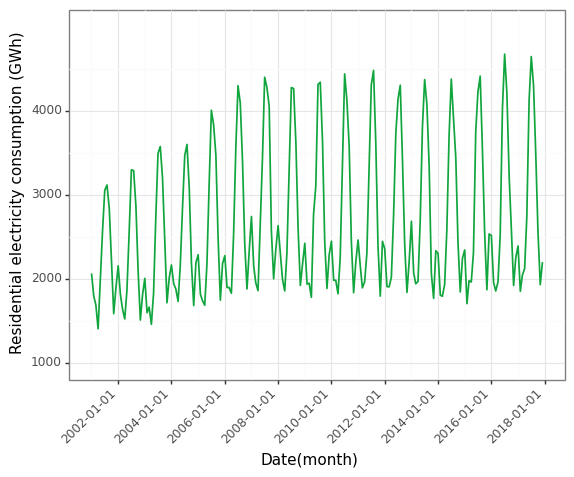

<ggplot: (-9223372036551253083)>

In [31]:
g1 = (ggplot(data = data) 
 + geom_line(aes(x = 'date', y = 'Q'), colour=color[1],  size=0.7) 
 + labs(x = "Date(month)",y = "Residential electricity consumption (GWh)")
 + scale_y_continuous(limits = [1000,5000], breaks = seq(1000,5000,1000))
 + theme_bw()
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

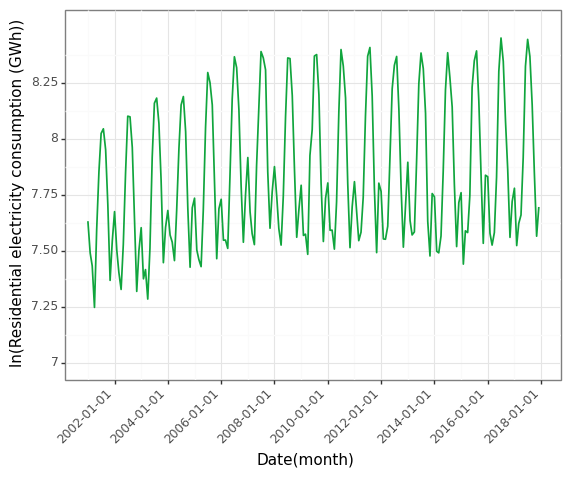

<ggplot: (-9223372036541006006)>

In [32]:
g1 = (ggplot(data = data) 
 + geom_line(aes(x = 'date', y = 'lnQ'), colour=color[1],  size=0.7) 
 + labs(x = "Date(month)",y = "ln(Residential electricity consumption (GWh))")
 + scale_y_continuous(limits = [7,8.5], breaks = seq(7,8.5,0.25))
 + theme_bw() 
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

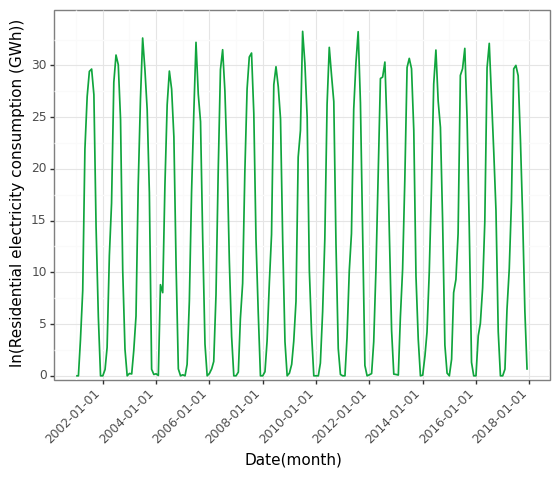

<ggplot: (-9223372036540925538)>

In [33]:
g1 = (ggplot(data = data) 
 + geom_line(aes(x = 'date', y = 'CLDD_avg'), colour=color[1],  size=0.7) 
 + labs(x = "Date(month)",y = "ln(Residential electricity consumption (GWh))")
 + scale_y_continuous(expand = [0.01,0.01],limits = [0,35], breaks = seq(0,35,5)) 
 + theme_bw() 
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

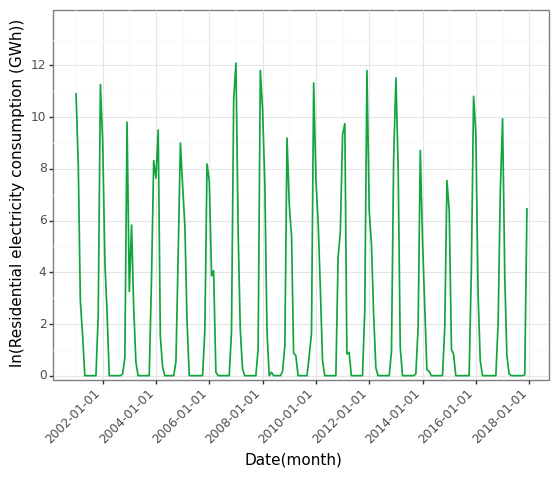

<ggplot: (-9223372036540879721)>

In [34]:
g1 = (ggplot(data = data) 
 + geom_line(aes(x = 'date', y = 'HTDD_avg'), colour=color[1],  size=0.7) 
 + labs(x = "Date(month)",y = "ln(Residential electricity consumption (GWh))")
 + scale_y_continuous(expand = [0.01,0.01],limits = [0,14], breaks = seq(0,14,2))
 + theme_bw() 
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

In [35]:
#Serial correlation

In [36]:
for x in ["lnQ","CLDD_avg", "HTDD_avg", "DX90_avg"]:
    data['D'+x]=data[x]-data[x].shift()

In [37]:
data.head()

,CLDD,DX32,DX70,DX90,HTDD,year,month,ym,ndays,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg,Q,date,lnQ,DlnQ,DCLDD_avg,DHTDD_avg,DDX90_avg
0,0,0,11,0,339,2001,1,2001m1,31,0.000000,10.935484,0.354839,0.000000,2063,2001-01-01,7.631917,NaN,NaN,NaN,NaN
1,0,0,11,0,228,2001,2,2001m2,28,0.000000,8.142857,0.392857,0.000000,1790,2001-02-01,7.489971,-0.141946,0.000000,-2.792627,0.000000
2,108,0,23,2,90,2001,3,2001m3,31,3.483871,2.903226,0.741935,0.064516,1690,2001-03-01,7.432484,-0.057487,3.483871,-5.239631,0.064516
3,247,0,27,11,47,2001,4,2001m4,30,8.233333,1.566667,0.900000,0.366667,1404,2001-04-01,7.247081,-0.185403,4.749462,-1.336559,0.302151
4,679,0,31,27,0,2001,5,2001m5,31,21.903226,0.000000,1.000000,0.870968,1984,2001-05-01,7.592870,0.345790,13.669892,-1.566667,0.504301


/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


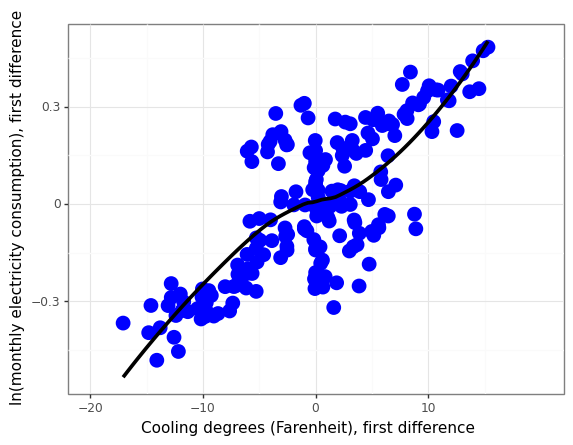

<ggplot: (313968027)>

In [38]:
(ggplot(data = data) 
 + geom_point(aes(x = 'DCLDD_avg', y = 'DlnQ'),size=2, stroke=2, fill="blue", color="blue") 
 + geom_smooth(aes(x = 'DCLDD_avg', y = 'DlnQ'),method="loess", se=False, colour="black", size=1.5, span=0.9)
 + labs(x = "Cooling degrees (Farenheit), first difference",y = "ln(monthly electricity consumption), first difference")
 + scale_x_continuous(limits = [-20,20], breaks = seq(-20,20, 10))
 + theme_bw() 
)


/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


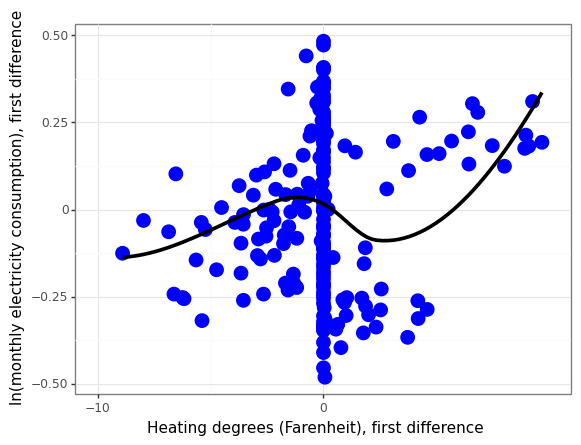

<ggplot: (314099285)>

In [39]:
(ggplot(data = data) 
 + geom_point(aes(x = 'DHTDD_avg', y = 'DlnQ'),size=2, stroke=2, fill="blue", color="blue") 
 + geom_smooth(aes(x = 'DHTDD_avg', y = 'DlnQ'),method="loess", se=False, colour="black", size=1.5, span=0.9)
 + labs(x = "Heating degrees (Farenheit), first difference",y = "ln(monthly electricity consumption), first difference") 
 + scale_x_continuous(limits = [-10,10], breaks = seq(-10,10, 10))
 + theme_bw() 
)

In [40]:
#Linear regressions

In [41]:
y,X = dmatrices("DlnQ ~ DCLDD_avg + DHTDD_avg",data)

In [42]:
reg1 = sm.OLS(y, X).fit()
reg_results = reg1.get_robustcov_results(cov_type='HAC',maxlags=18)

In [43]:
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     1114.
Date:                Sat, 17 Oct 2020   Prob (F-statistic):          3.65e-109
Time:                        17:56:59   Log-Likelihood:                 182.98
No. Observations:                 203   AIC:                            -360.0
Df Residuals:                     200   BIC:                            -350.0
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.002      0.477      0.634      -0.003       0.005
DCLDD_avg      0.0307      0.001     33.658      0.000       0.029       0.032
DHTDD_avg      0.0367      0.003     10.609      0.000       0.030       0.044
==============================================================================
Omnibus:                        4.221   Durbin-Watson:                   2.547
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                4.632
Skew:                          -0.164   Prob(JB):                       0.0986
Kurtosis:                       3.664   Cond. No.                         6.85
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [50]:
y,X = dmatrices("DlnQ ~ DCLDD_avg + DHTDD_avg + C(month)",data)

In [51]:
reg4 = sm.OLS(y, X).fit()

In [52]:
reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     281.4
Date:                Sat, 17 Oct 2020   Prob (F-statistic):          4.99e-116
Time:                        18:28:57   Log-Likelihood:                 321.40
No. Observations:                 203   AIC:                            -614.8
Df Residuals:                     189   BIC:                            -568.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0919      0.013      6.957      0.000       0.066       0.118
C(month)[T.2]     -0.2740      0.018    -15.022      0.000      -0.310      -0.238
C(month)[T.3]     -0.1219      0.019     -6.314      0.000      -0.160      -0.084
C(month)[T.4]     -0.1837      0.019     -9.480      0.000      -0.222      -0.145
C(month)[T.5]      0.0327      0.023      1.418      0.158      -0.013       0.078
C(month)[T.6]      0.0807      0.025      3.244      0.001       0.032       0.130
C(month)[T.7]      0.0580      0.019      3.046      0.003       0.020       0.096
C(month)[T.8]     -0.0854      0.018     -4.673      0.000      -0.121      -0.049
C(month)[T.9]     -0.1757      0.020     -8.985      0.000      -0.214      -0.137
C(month)[T.10]    -0.2464      0.025     -9.806      0.000      -0.296      -0.197
C(month)[T.11]    -0.2418      0.024    -10.004      0.000      -0.289      -0.194
C(month)[T.12]     0.0672      0.026      2.561      0.011       0.015       0.119
DCLDD_avg          0.0169      0.002     10.509      0.000       0.014       0.020
DHTDD_avg          0.0140      0.002      5.902      0.000       0.009       0.019
==============================================================================
Omnibus:                        0.278   Durbin-Watson:                   2.395
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.428
Skew:                          -0.047   Prob(JB):                        0.808
Kurtosis:                       2.796   Cond. No.                         90.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
reg4.get_robustcov_results(cov_type='HAC',maxlags=18).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     2310.
Date:                Sat, 17 Oct 2020   Prob (F-statistic):          1.64e-200
Time:                        18:29:17   Log-Likelihood:                 321.40
No. Observations:                 203   AIC:                            -614.8
Df Residuals:                     189   BIC:                            -568.4
Df Model:                          13                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0919      0.013      7.115      0.000       0.066       0.117
C(month)[T.2]     -0.2740      0.018    -15.446      0.000      -0.309      -0.239
C(month)[T.3]     -0.1219      0.024     -5.009      0.000      -0.170      -0.074
C(month)[T.4]     -0.1837      0.029     -6.427      0.000      -0.240      -0.127
C(month)[T.5]      0.0327      0.013      2.598      0.010       0.008       0.057
C(month)[T.6]      0.0807      0.031      2.621      0.009       0.020       0.141
C(month)[T.7]      0.0580      0.014      4.164      0.000       0.031       0.086
C(month)[T.8]     -0.0854      0.015     -5.689      0.000      -0.115      -0.056
C(month)[T.9]     -0.1757      0.014    -12.491      0.000      -0.203      -0.148
C(month)[T.10]    -0.2464      0.029     -8.472      0.000      -0.304      -0.189
C(month)[T.11]    -0.2418      0.033     -7.424      0.000      -0.306      -0.178
C(month)[T.12]     0.0672      0.022      3.087      0.002       0.024       0.110
DCLDD_avg          0.0169      0.002      7.106      0.000       0.012       0.022
DHTDD_avg          0.0140      0.003      4.155      0.000       0.007       0.021
==============================================================================
Omnibus:                        0.278   Durbin-Watson:                   2.395
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.428
Skew:                          -0.047   Prob(JB):                        0.808
Kurtosis:                       2.796   Cond. No.                         90.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [54]:
y,X = dmatrices("DlnQ ~ DCLDD_avg + DHTDD_avg + C(month) + lag(DlnQ)",data)
reg6 = sm.OLS(y, X).fit()
reg6.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     261.6
Date:                Sat, 17 Oct 2020   Prob (F-statistic):          1.29e-114
Time:                        18:29:49   Log-Likelihood:                 320.67
No. Observations:                 202   AIC:                            -611.3
Df Residuals:                     187   BIC:                            -561.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0923      0.018      5.092      0.000       0.057       0.128
C(month)[T.2]     -0.2792      0.020    -13.770      0.000      -0.319      -0.239
C(month)[T.3]     -0.1228      0.031     -3.941      0.000      -0.184      -0.061
C(month)[T.4]     -0.1843      0.022     -8.249      0.000      -0.228      -0.140
C(month)[T.5]      0.0319      0.024      1.304      0.194      -0.016       0.080
C(month)[T.6]      0.0805      0.027      2.936      0.004       0.026       0.135
C(month)[T.7]      0.0582      0.022      2.623      0.009       0.014       0.102
C(month)[T.8]     -0.0854      0.018     -4.673      0.000      -0.121      -0.049
C(month)[T.9]     -0.1761      0.026     -6.746      0.000      -0.228      -0.125
C(month)[T.10]    -0.2470      0.040     -6.197      0.000      -0.326      -0.168
C(month)[T.11]    -0.2427      0.047     -5.176      0.000      -0.335      -0.150
C(month)[T.12]     0.0661      0.040      1.658      0.099      -0.013       0.145
DCLDD_avg          0.0169      0.002      9.584      0.000       0.013       0.020
DHTDD_avg          0.0140      0.002      5.839      0.000       0.009       0.019
lag(DlnQ)         -0.0021      0.062     -0.034      0.973      -0.125       0.121
==============================================================================
Omnibus:                        0.182   Durbin-Watson:                   2.406
Prob(Omnibus):                  0.913   Jarque-Bera (JB):                0.322
Skew:                          -0.043   Prob(JB):                        0.851
Kurtosis:                       2.824   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
y,X = dmatrices("""DlnQ ~ DCLDD_avg +
                          lag(DCLDD_avg) +
                          lag(lag(DCLDD_avg)) +
                          DHTDD_avg + 
                          lag(DHTDD_avg) +
                          lag(lag(DHTDD_avg)) +
                          C(month)""",data)
reg7 = sm.OLS(y, X).fit()
reg7.get_robustcov_results(cov_type='HAC',maxlags=18).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     3105.
Date:                Sat, 17 Oct 2020   Prob (F-statistic):          2.94e-215
Time:                        18:53:54   Log-Likelihood:                 330.98
No. Observations:                 201   AIC:                            -626.0
Df Residuals:                     183   BIC:                            -566.5
Df Model:                          17                                         
Covariance Type:                  HAC                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0466      0.027      1.751      0.082      -0.006       0.099
C(month)[T.2]          -0.2064      0.026     -7.853      0.000      -0.258      -0.155
C(month)[T.3]          -0.0414      0.042     -0.997      0.320      -0.123       0.041
C(month)[T.4]          -0.1239      0.045     -2.724      0.007      -0.214      -0.034
C(month)[T.5]           0.0383      0.048      0.805      0.422      -0.056       0.132
C(month)[T.6]           0.0415      0.052      0.796      0.427      -0.061       0.145
C(month)[T.7]           0.0239      0.055      0.430      0.668      -0.086       0.133
C(month)[T.8]          -0.0641      0.038     -1.676      0.096      -0.140       0.011
C(month)[T.9]          -0.1085      0.031     -3.477      0.001      -0.170      -0.047
C(month)[T.10]         -0.1358      0.033     -4.093      0.000      -0.201      -0.070
C(month)[T.11]         -0.1054      0.043     -2.474      0.014      -0.190      -0.021
C(month)[T.12]          0.1335      0.026      5.085      0.000       0.082       0.185
DCLDD_avg               0.0200      0.002      8.368      0.000       0.015       0.025
lag(DCLDD_avg)          0.0060      0.002      2.727      0.007       0.002       0.010
lag(lag(DCLDD_avg))     0.0009      0.002      0.587      0.558      -0.002       0.004
DHTDD_avg               0.0191      0.003      5.746      0.000       0.013       0.026
lag(DHTDD_avg)          0.0112      0.003      3.362      0.001       0.005       0.018
lag(lag(DHTDD_avg))     0.0002      0.003      0.058      0.954      -0.005       0.006
==============================================================================
Omnibus:                        0.021   Durbin-Watson:                   2.401
Prob(Omnibus):                  0.989   Jarque-Bera (JB):                0.106
Skew:                          -0.018   Prob(JB):                        0.949
Kurtosis:                       2.894   Cond. No.                         371.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [58]:
data["DDCLDD_avg"]=data['DCLDD_avg']-data['DCLDD_avg'].shift()
data["DDHTDD_avg"]=data['DHTDD_avg']-data['DHTDD_avg'].shift()

In [57]:
y,X = dmatrices("""DlnQ ~ lag(lag(DCLDD_avg)) +
                          lag(lag(DHTDD_avg)) + 
                          DDCLDD_avg + DDHTDD_avg + 
                          lag(DDCLDD_avg) + lag(DDHTDD_avg) + 
                          C(month)""",data)

In [58]:
reg8 = sm.OLS(y, X).fit()
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     1739.
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          1.22e-170
Time:                        00:06:43   Log-Likelihood:                 261.47
No. Observations:                 201   AIC:                            -506.9
Df Residuals:                     193   BIC:                            -480.5
Df Model:                           7                                         
Covariance Type:                  HAC                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0556      0.015     -3.767      0.000      -0.085      -0.026
DCLDD_avg               0.0291      0.001     20.725      0.000       0.026       0.032
lag(DCLDD_avg)          0.0095      0.002      6.026      0.000       0.006       0.013
lag(lag(DCLDD_avg))    -0.0025      0.001     -1.877      0.062      -0.005       0.000
DHTDD_avg               0.0311      0.003      9.677      0.000       0.025       0.037
lag(DHTDD_avg)          0.0235      0.003      8.667      0.000       0.018       0.029
lag(lag(DHTDD_avg))    -0.0048      0.002     -2.533      0.012      -0.009      -0.001
month                   0.0103      0.003      3.871      0.000       0.005       0.016
==============================================================================
Omnibus:                        2.439   Durbin-Watson:                   2.603
Prob(Omnibus):                  0.295   Jarque-Bera (JB):                2.302
Skew:                          -0.090   Prob(JB):                        0.316
Kurtosis:                       3.492   Cond. No.                         34.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [52]:
data['DDCLDD_avg'] = data['DCLDD_avg']-data['DCLDD_avg'].shift()
data['DDHTDD_avg'] = data['DHTDD_avg']-data['DHTDD_avg'].shift()

In [53]:
y,X = dmatrices("DlnQ ~ lag(lag(DCLDD_avg)) + lag(lag(DHTDD_avg)) + DDCLDD_avg + DDHTDD_avg + lag(DDCLDD_avg) + \
                 lag(DDHTDD_avg) + month",data)

In [56]:
reg = sm.OLS(y, X).fit()
reg_results = reg.get_robustcov_results(cov_type='HAC',maxlags=18)
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     1739.
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          1.22e-170
Time:                        00:05:31   Log-Likelihood:                 261.47
No. Observations:                 201   AIC:                            -506.9
Df Residuals:                     193   BIC:                            -480.5
Df Model:                           7                                         
Covariance Type:                  HAC                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0556      0.015     -3.767      0.000      -0.085      -0.026
lag(lag(DCLDD_avg))     0.0361      0.001     53.527      0.000       0.035       0.037
lag(lag(DHTDD_avg))     0.0497      0.004     12.049      0.000       0.042       0.058
DDCLDD_avg              0.0291      0.001     20.725      0.000       0.026       0.032
DDHTDD_avg              0.0311      0.003      9.677      0.000       0.025       0.037
lag(DDCLDD_avg)         0.0386      0.001     34.315      0.000       0.036       0.041
lag(DDHTDD_avg)         0.0545      0.003     16.258      0.000       0.048       0.061
month                   0.0103      0.003      3.871      0.000       0.005       0.016
==============================================================================
Omnibus:                        2.439   Durbin-Watson:                   2.603
Prob(Omnibus):                  0.295   Jarque-Bera (JB):                2.302
Skew:                          -0.090   Prob(JB):                        0.316
Kurtosis:                       3.492   Cond. No.                         27.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [59]:
data.head()

,CLDD,DX32,DX70,DX90,HTDD,year,month,ym,ndays,CLDD_avg,...,DX90_avg,Q,date,lnQ,DlnQ,DCLDD_avg,DHTDD_avg,DDX90_avg,DDCLDD_avg,DDHTDD_avg
0,0,0,11,0,339,2001,0,2001m1,31,0.000000,...,0.000000,2063,2001-01-01,7.631917,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,11,0,228,2001,1,2001m2,28,0.000000,...,0.000000,1790,2001-02-01,7.489971,-0.141946,0.000000,-2.792627,0.000000,NaN,NaN
2,108,0,23,2,90,2001,2,2001m3,31,3.483871,...,0.064516,1690,2001-03-01,7.432484,-0.057487,3.483871,-5.239631,0.064516,3.483871,-2.447005
3,247,0,27,11,47,2001,3,2001m4,30,8.233333,...,0.366667,1404,2001-04-01,7.247081,-0.185403,4.749462,-1.336559,0.302151,1.265591,3.903072
4,679,0,31,27,0,2001,4,2001m5,31,21.903226,...,0.870968,1984,2001-05-01,7.592870,0.345790,13.669892,-1.566667,0.504301,8.920430,-0.230108
